<div style="width: 100%; clear: both;">
  <div style="float: left; width: 50%;">
    <img src="https://brandemia.org/sites/default/files/sites/default/files/uoc_nuevo_logo.jpg" align="left" style="width: 80%;">
  </div>
  <div style="float: right; width: 50%; text-align: right;">
    <h3 style="text-align: left; font-weight: bold;">Optimización del sistema de bicicletas compartidas en la ciudad de Valencia.</h3>
    <p style="text-align: left; font-weight: bold; font-size: 100%;">Análisis predictivo, rutas de reparto para el balanceo y gestión eficiente de las estaciones.</p>
    <p style="margin: 0; text-align: right;">Jose Luis Santos Durango</p>
    <hr style="border-top: 1px solid #ccc; margin: 10px 0;">
    <p style="margin: 0; padding-top: 22px; text-align:right;">data_analysis.ipynb · M2.879 · Trabajo Final de Máster · Área 2</p>
    <p style="margin: 0; text-align:right;">2023-2 · Máster universitario en Ciencia de datos (Data science)</p>
    <p style="margin: 0; text-align:right;">Estudios de Informática, Multimedia y Telecomunicación</p>
  </div>
</div>
<div style="width:100%;">&nbsp;</div>

# Análisis descriptivo de los datos: calidad de los datos, imputación de valores, reducción de la dimensionalidad.

En este notebook vamos a realizar el análisis descriptivo de los datos resultantes de los procesos ETL realizados. Tenemos 3 fuentes de datos distintas: datos sobre el clima, datos sobre las estaciones y el área donde se localizan, y datos sobre las estaciones de Valenbisi. Estos últimos los tenemos a nivel horario: valor de referencia y valor medio por hora.


1. [Datos metorológicos y atomosféricos](#1)
        1.1 Creación del dataframe y análisis inicial
        1.2 Valores nulos y outliers
            1.2.1 Imputación de valores nulos
            1.2.2 Imputación de outliers
        1.3 Análisis de correlación y de impacto entre las variables
        1.4 Almacenamiento de los datos
2. [Datos de las estaciones: geográficos, económicos, zonas verdes](#2)
        2.1 Análisis de valores nulos y outliers
        2.2 Almacenamiento de los datos
3. [Datos de los movimientos en las estaciones](#3)
        3.1 Creación del dataset y eliminación de registros erróneos
        3.2 Análisis descriptivo de los mivimientos en las estaciones
        3.3 Reducción de la dimensionalidad
4. [Creación del conjunto de datos para el modelo predictivo](#4)

In [1]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import ceil
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.impute import KNNImputer

<a id='1'></a>
## 1. Datos meteorológicos y atmosféricos

### 1.1 Creación del dataframe y análisis inicial

En primer lugar vamos a cargar los datos que tenemos de la climatología (los cuales ya están filtrados por el año 2021) y vamos a realizar un primer análisis de valores nulos para las variables meteorológicas.

In [3]:
# read the dataset as a dataframe
data = pd.read_csv("./data_processed/weather_conditions.txt")


# input datetime as timestamp format
data['timestamp'] = pd.to_datetime(data['fecha'] + ' ' + data['hora'], format='%Y-%m-%d %H:%M:%S')
data.drop(columns=['fecha', 'hora'], inplace=True)
columns = list(data.columns)
columns.insert(0, columns.pop(columns.index('timestamp')))

### 1.2 Valores nulos y outliers

En primer lugar vamos a crear una tabla para estudiar los valores nulos y los outliers de cada variable.

Para los valores nulos, simplemente contaremos cuántos valores nulos tiene una variable y lo escribiremos en la tabla como entero y como porcentaje del total. Para los valores outliers, lo que haremos será calcular los cuartiles y se calculan los límites inferior y superior de los valores de la siguiente forma:

- Límite inferior = Q1 - 1.5 * IQR
- Límite superior = Q3 + 1.5 * IQR

Después, se hace un conteo de todos los valores que son outliers y se visualizan en la tabla, junto con el porcentaje del total que representan.

In [4]:
data_numeric = data.drop(columns=['timestamp'])

# data table with null values and percentage of total rows
total_values = data_numeric.shape[0]
null_counts = data_numeric.isnull().sum()
null_percentages = (null_counts / total_values) * 100

# data table with outliers values and percentage of total rows
Q1 = data_numeric.quantile(0.25)
Q3 = data_numeric.quantile(0.75)
IQR = Q3 - Q1
outliers_counts = ((data_numeric < (Q1 - 1.5 * IQR)) | (data_numeric > (Q3 + 1.5 * IQR))).sum()
outliers_percentage = ((data_numeric < (Q1 - 1.5 * IQR)) | (data_numeric > (Q3 + 1.5 * IQR))).mean() * 100


data_info = pd.DataFrame({'Valores Nulos': null_counts, 
                          'Porcentaje de valores nulos': null_percentages,
                          'Valores Outlier': outliers_counts,
                          'Porcentaje de valores outliers': outliers_percentage
                         })

data_info['Porcentaje de valores nulos'] = data_info['Porcentaje de valores nulos'].apply(lambda x: '{:.2f}%'.format(x))
data_info['Porcentaje de valores outliers'] = data_info['Porcentaje de valores outliers'].apply(lambda x: '{:.2f}%'.format(x))

In [5]:
data_info

,Valores Nulos,Porcentaje de valores nulos,Valores Outlier,Porcentaje de valores outliers
velocidad_del_viento,128,1.46%,300,3.42%
temperatura,130,1.48%,0,0.00%
humedad_relativa,1005,11.47%,0,0.00%
precipitacion,90,1.03%,297,3.39%
velocidad_maxima_del_viento,128,1.46%,257,2.93%
radiacion,124,1.42%,325,3.71%
no2,160,1.83%,575,6.56%
o3,8760,100.00%,0,0.00%
co,8760,100.00%,0,0.00%


#### 1.2.1 Imputación de valores nulos

Con los resultados de la tabla anterior tomaremos las siguientes decisiones:

- Las columnas **O3** y **CO** pueden ser eliminadas ya que no contienen valores.

- Para imputar los valores nulos de las variables con porcentaje bajo (<5%) usaremos el método **kNN** de vecinos más cercanos, con un total de 5 vecinos. Como todas tienen porcentajes muy bajos de valores nulos, no daremos importancia a la orden de imputación. Las variables a tener en cuenta en la imputación serán las siguientes:
    - Para **velocidad del viento**: temperatura, velocidad máxima del viento y fecha y hora.
    - Para **temperatura**: velocidad del viento, precipitación y radiación.
    - Para **precipitación**: fecha y hora.
    - Para **velocidad máxima del viento**: temperatura, velocidad del viento y fecha y hora.
    - Para **radiación**: NO2, temperatura y fecha y hora.
    - Para la variable **NO2** decidimos imputar los valores medios de las 12 horas previas y las 12 horas posteriores, luego tomaremos 23 vecinos.    
    



In [6]:
# delete 03 and CO columns
data.drop(columns=['o3', 'co'], inplace=True)

In [7]:
# create a copy for imputting values
data_impute = data.copy()

# we need timestamp as int for kNN
data_impute['timestamp_int'] = data_impute['timestamp'].view('int64')


# definition of the columns for imputting values
vv_columns_for_imputation = ['velocidad_del_viento',
                             'temperatura',
                             'velocidad_maxima_del_viento',
                             'timestamp_int'
                            ]
temperatura_columns_for_imputation = ['temperatura',
                                      'radiacion',
                                      'velocidad_del_viento',
                                      'precipitacion'
                                     ]
precipitacion_columns_for_imputation = ['precipitacion',
                                        'timestamp_int'
                                       ]
vv_max_columns_for_imputation = ['velocidad_maxima_del_viento',
                                 'temperatura',
                                 'velocidad_del_viento',
                                 'timestamp_int'
                                ]
radiacion_columns_for_imputation = ['radiacion',
                                    'no2',
                                    'temperatura',
                                    'timestamp_int']


# first imputer with 5 neighbours
imputer = KNNImputer(n_neighbors=5)

# Imputamos los valores nulos en la columna 'temperatura' basándonos en las demás columnas
data_impute['velocidad_del_viento'] = imputer.fit_transform(data_impute[vv_columns_for_imputation])[:, 0]
data_impute['temperatura'] = imputer.fit_transform(data_impute[temperatura_columns_for_imputation])[:, 0]
data_impute['precipitacion'] = imputer.fit_transform(data_impute[precipitacion_columns_for_imputation])[:, 0]
data_impute['velocidad_maxima_del_viento'] = imputer.fit_transform(data_impute[vv_max_columns_for_imputation])[:, 0]
data_impute['radiacion'] = imputer.fit_transform(data_impute[radiacion_columns_for_imputation])[:, 0]

# second imputer for NO2 with 23 neighbours
imputer = KNNImputer(n_neighbors=23)
data_impute['no2'] = imputer.fit_transform(data_impute[['no2','timestamp_int']])[:, 0]

# let's delete the timestamp_int variable
data_impute.drop(columns=['timestamp_int'], inplace=True)

# let's check if we still have null values
data_impute.isnull().sum()



velocidad_del_viento              0
temperatura                       0
humedad_relativa               1005
precipitacion                     0
velocidad_maxima_del_viento       0
radiacion                         0
no2                               0
timestamp                         0
dtype: int64

Como podemos ver en el resultado anterior, ya solo nos quedan valores nulos en la variable humedad_relativa. Para poder estudiar este valor, vamos a realizar un visualización de los valores nulos que tenemos por mes.

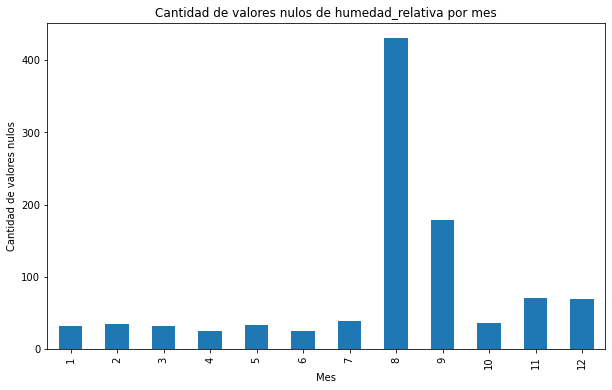

In [8]:
# filter the dataframe with null values in humedad_relativa variable
null_humidity_data = data[data['humedad_relativa'].isnull()]

# let's crete a copy to avoid some warnings
null_humidity_data = null_humidity_data.copy()
null_humidity_data.loc[:, 'mes'] = null_humidity_data['timestamp'].dt.month

# group by month and count null values
null_humidity_by_month = null_humidity_data.groupby('mes').size()

# visualization
plt.figure(figsize=(10, 6))
null_humidity_by_month.plot(kind='bar')
plt.xlabel('Mes')
plt.ylabel('Cantidad de valores nulos')
plt.title('Cantidad de valores nulos de humedad_relativa por mes')
plt.show()


Podemos ver que la mayoría de los registros con humedad relativa nula se localizan en el mes de agosto. Para imputar los valores nulos de humedad relativa, vamos a considerar los valores medios de humedad por mes y hora.

In [9]:
# group by month and hour
data_impute['mes'] = data_impute['timestamp'].dt.month
data_impute['hora'] = data_impute['timestamp'].dt.hour

# calculate the mean value for each group
humidity_mean_by_month_hour = data_impute.groupby(['mes', 'hora'])['humedad_relativa'].mean()

# imput the values
for index, row in data_impute.iterrows():
    if pd.isnull(row['humedad_relativa']):
        month = row['timestamp'].month
        hour = row['timestamp'].hour
        mean_value = humidity_mean_by_month_hour.loc[(month, hour)]
        data_impute.at[index, 'humedad_relativa'] = mean_value

# let's delete mes, hora variables
data_impute.drop(columns=['mes', 'hora'], inplace=True)
        
# let's check if we still have null values
data_impute.isnull().sum()

velocidad_del_viento           0
temperatura                    0
humedad_relativa               0
precipitacion                  0
velocidad_maxima_del_viento    0
radiacion                      0
no2                            0
timestamp                      0
dtype: int64

#### 1.2.2 Imputación de outliers

En esta sección vamos a realizar un estudio visual de los posibles outliers de los datos atmosféricos. Para ello vamos a usar un diagrama de cajas con los cuantiles para poder ver si son outliers considerables, o podemos trabajar con ellos. Del análisis inicial, sabemos que las variables temperatura y humedad_relativa no tienen outliers, por lo que las excluiremos del estudio.

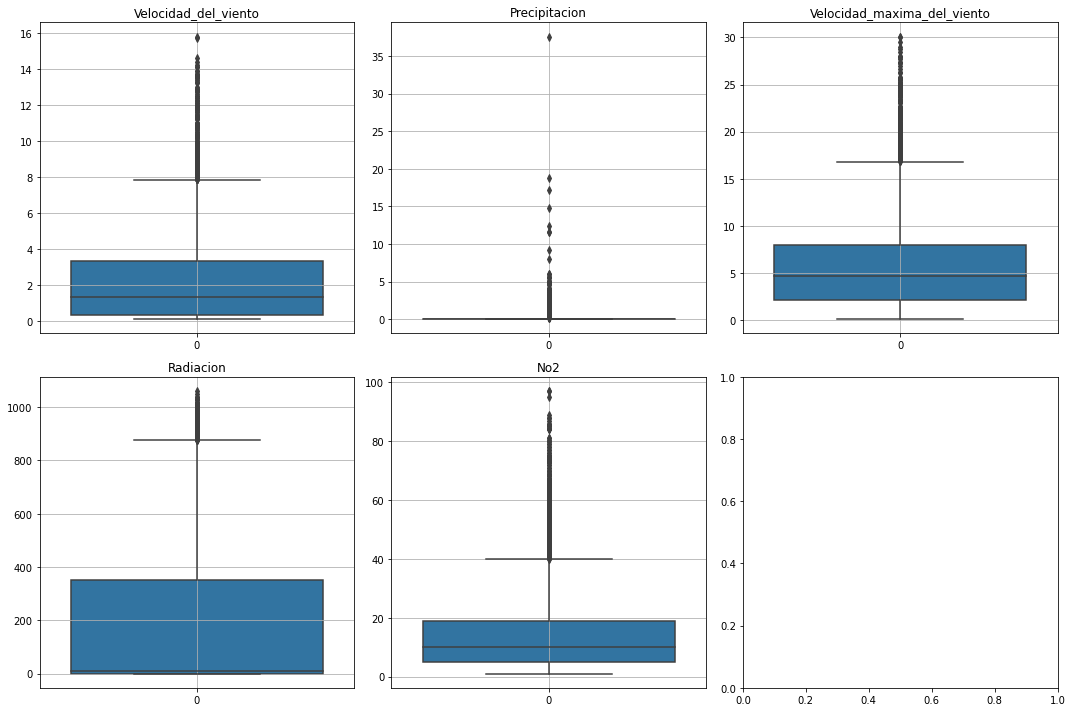

In [10]:
# numeric variables to plot
variables = ['velocidad_del_viento','precipitacion', 'velocidad_maxima_del_viento', 'radiacion', 'no2']

# Formating for subgraphs
num_variables = len(variables)
num_plots_per_row = 3
num_rows = -(-num_variables // num_plots_per_row)  # ceil division

# Create the subgraphs
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, num_rows * 5))

# Set-up subgraphs position
axes = axes.flatten()

# Iteración sobre las columnas y graficar un diagrama de cajas para cada una
for i, col in enumerate(variables):
    sns.boxplot(data=data_impute[col], ax=axes[i])
    axes[i].set_title(col.capitalize())  # Variable title
    axes[i].set_ylabel('')  # Quitar la etiqueta del eje y para ahorrar espacio
    axes[i].set_xlabel('')  # Quitar la etiqueta del eje x para ahorrar espacio
    axes[i].grid(True)  # Activar las líneas de la cuadrícula en cada diagrama de cajas

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()


Del estudio visual, podemos deducir que las dos variables referentes al viento, son variables sin outliers puesto que no se salen de un rango posible de los valores de velocidad del viento. Precipitación, aparentemente tiene un valor que es bastante mayor que el resto, pero también descartaremos que sea un outlier porque no se trata de un valor anómalo, que además en la zona del mediterráneo podría explicarse con una dana puntual. Respecto a los valores de NO2, en la [página del ministerio de medioambiente](https://www.miteco.gob.es/es/calidad-y-evaluacion-ambiental/temas/atmosfera-y-calidad-del-aire/calidad-del-aire/salud/oxidos-nitrogeno.html) se indica que los valores medios se sitúan en 40, siendo el límite 200. Luego también descartamos que se trate de outliers, al estar los valores por debajo de 100. Para la variable radiación, vamos a realizar un estudio de cuándo se producen valores superiores a 400, por hora, mes y día.

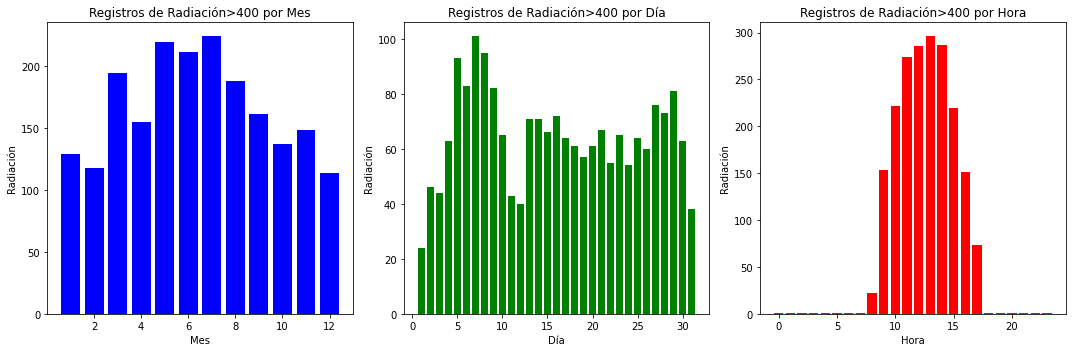

In [11]:
# filter dataframe to get row with radiacion higher than 400
radiation_above_400 = data_impute[data_impute['radiacion'] > 400].copy()
radiation_above_400['hora'] = radiation_above_400['timestamp'].dt.hour
radiation_above_400['mes'] = radiation_above_400['timestamp'].dt.month
radiation_above_400['dia'] = radiation_above_400['timestamp'].dt.day

# define the data for the graphs
data_mes = radiation_above_400.groupby('mes')['radiacion'].count()
data_dia = radiation_above_400.groupby('dia')['radiacion'].count()
data_hora = radiation_above_400.groupby('hora')['radiacion'].count()

# create the figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# define the graphs for month
axs[0].bar(data_mes.index, data_mes.values, color='blue')
axs[0].set_title('Registros de Radiación>400 por Mes')
axs[0].set_xlabel('Mes')
axs[0].set_ylabel('Radiación')

# define the graphs for day
axs[1].bar(data_dia.index, data_dia.values, color='green')
axs[1].set_title('Registros de Radiación>400 por Día')
axs[1].set_xlabel('Día')
axs[1].set_ylabel('Radiación')

# define the graphs for hour
axs[2].bar(data_hora.index, data_hora.values, color='red')
axs[2].set_title('Registros de Radiación>400 por Hora')
axs[2].set_xlabel('Hora')
axs[2].set_ylabel('Radiación')

# set-up the graphs
plt.tight_layout()

# show the graphs
plt.show()

De los gráficos anteriores, podemos ver que los valores se distribuyen de forma normal. El único gráfico que no nos da información útil es el gráfico por día, pero debido a que es muy variable, dependiendo de la luz solar, es normal que el resultado no se distribuya de forma normal. Sin embargo los meses y horas, al ser variables estacionarias, si que nos dan información de la distribución de la radiación solar. Luego, decidimos no imputar ninguno de estos valores, al mostrar una distribución normal.

### 1.3 Análisis de correlación y de impacto entre las variables

Finalmente, para ver si podemos descartar alguna de las variables, vamos a realizar un estudio de correlación entre las variables numéricas mediante la matriz de correlación.

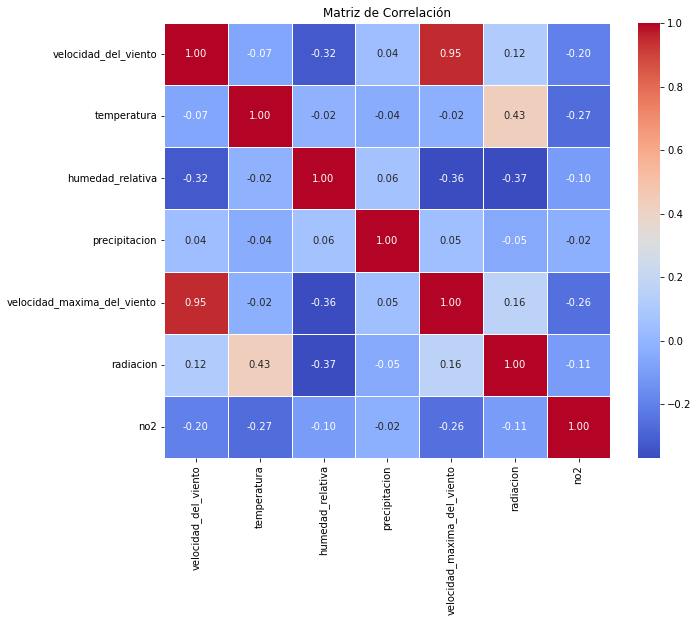

In [12]:
# heatmap for the correlation parameter between the variables
correlation_matrix = data_impute.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()


### 1.4 Almacenamiento de los datos

Dada la alta correlación entre las variables velocidad_del_viento y velocidad_maxima_del_viento, decidimos eliminar la de velocidad máxima en los datos. Creamos un dataframe con las variables resultantes, para usarlo posteriormente con el resto de los datos.

In [13]:
df_weather = data_impute.drop(columns=['velocidad_maxima_del_viento'])

<a id='2'></a>
## 2. Datos de las estaciones: geográficos, económicos, zonas verdes

In [14]:
# read the dataset as a dataframe
data = pd.read_csv("./data_processed/stations.txt")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   number                  276 non-null    int64  
 1   address                 276 non-null    object 
 2   bike_stands             276 non-null    int64  
 3   lat                     276 non-null    float64
 4   lng                     276 non-null    float64
 5   position                276 non-null    object 
 6   precio_2022_euros_m2    272 non-null    float64
 7   barrio                  276 non-null    object 
 8   distrito                276 non-null    object 
 9   close_green_area_shape  276 non-null    float64
 10  close_green_area_name   276 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 23.8+ KB


### 2.1 Análisis de outliers

Como con los datos anteriores, vamos a mostrar en una tabla los outliers para las variables numéricas. Sabemos que valores nulos no hay por la impresión de la información del dataframe.

In [15]:
data_numeric = data[['bike_stands', 'lat', 'lng', 'precio_2022_euros_m2', 'close_green_area_shape']]

# data table with outliers values and percentage of total rows
Q1 = data_numeric.quantile(0.25)
Q3 = data_numeric.quantile(0.75)
IQR = Q3 - Q1
outliers_counts = ((data_numeric < (Q1 - 1.5 * IQR)) | (data_numeric > (Q3 + 1.5 * IQR))).sum()
outliers_percentage = ((data_numeric < (Q1 - 1.5 * IQR)) | (data_numeric > (Q3 + 1.5 * IQR))).mean() * 100


data_info = pd.DataFrame({'Valores Outlier': outliers_counts,
                          'Porcentaje de valores outliers': outliers_percentage
                         })

data_info['Porcentaje de valores outliers'] = data_info['Porcentaje de valores outliers'].apply(lambda x: '{:.2f}%'.format(x))
data_info

,Valores Outlier,Porcentaje de valores outliers
bike_stands,24,8.70%
lat,0,0.00%
lng,0,0.00%
precio_2022_euros_m2,6,2.17%
close_green_area_shape,37,13.41%


Vamos a realizar un estudio de los outliers. Para ello, vamos a ver los registros donde se producen outliers y evaluaremos si lo son.

In [16]:
columns_to_check = ['bike_stands', 'lat', 'lng', 'precio_2022_euros_m2', 'close_green_area_shape']

# calculate the bounds
Q1 = data[columns_to_check].quantile(0.25)
Q3 = data[columns_to_check].quantile(0.75)
IQR = Q3 - Q1

# define the conditions
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# filter the outliers
outliers = ((data[columns_to_check] < lower_bound) | (data[columns_to_check] > upper_bound))

# add the outlier_condition in a new column for each variable
for column in columns_to_check:
    data[f'{column}_outlier'] = outliers[column]

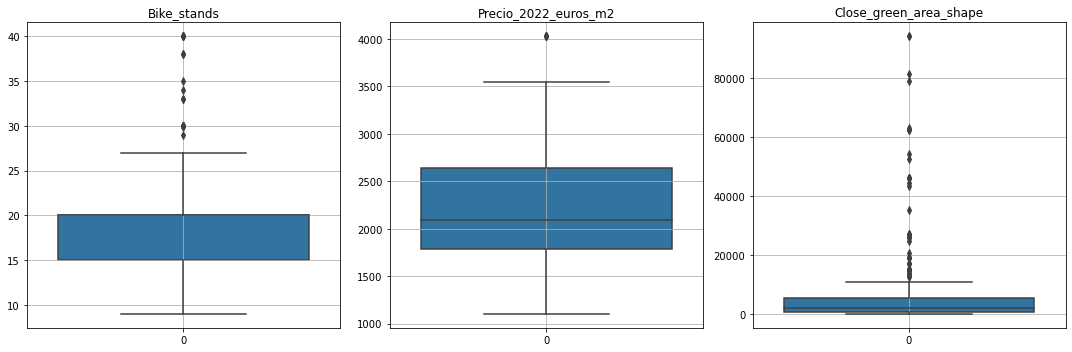

In [17]:
# numeric variables to plot
variables = ['bike_stands','precio_2022_euros_m2','close_green_area_shape']

# Formating for subgraphs
num_variables = len(variables)
num_plots_per_row = 3
num_rows = -(-num_variables // num_plots_per_row)  # ceil division

# Create the subgraphs
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, num_rows * 5))

# Set-up subgraphs position
axes = axes.flatten()

# Iteración sobre las columnas y graficar un diagrama de cajas para cada una
for i, col in enumerate(variables):
    sns.boxplot(data=data[col], ax=axes[i])
    axes[i].set_title(col.capitalize())  # Variable title
    axes[i].set_ylabel('')  # Quitar la etiqueta del eje y para ahorrar espacio
    axes[i].set_xlabel('')  # Quitar la etiqueta del eje x para ahorrar espacio
    axes[i].grid(True)  # Activar las líneas de la cuadrícula en cada diagrama de cajas

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Con los resultados anteriores, vamos a proceder a:

- Revisar las estaciones que tengan 40 parkings y ver si realmente es un outlier.
- Respecto al precio del metro cuadrado, no lo consideramos un outlier al contrastar con [otras fuentes](https://www.lasprovincias.es/valencia-ciudad/barrios-valencia-caros-comprar-vivienda-20240223010225-nt.html#:~:text=El%20Pla%20del%20Remei%20(4.486,por%20el%20portal%20inmobiliario%20Fotocasa.).
- Respecto a las zonas verdes, vamos a visualizarlas en un mapa, para poder evaluar si son outliers por un error de decimales, o si se trata de zonas verdes de gran dimensión, como los tramos del río Turia.

#### Evaluación de outliers en zonas verdes de gran dimensión

Para evaluar si una zona verde es un outlier, vamos a proceder del siguiente modo:
- Sacaremos un listado de las zonas verdes que son outliers del dataset de stations.
- Sobre el dataset original de zonas verdes vamos a filtrar aquellas zonas verdes cuyo nombre esté en ese listado.
- Representaremos sobre un mapa de la ciudad de Valencia, las zonas verdes y evalúaremos los resultados

In [18]:
# filter the outliers in green area shape
shape_true_data = data[data['close_green_area_shape_outlier'] == True]
green_area_names = shape_true_data['close_green_area_name'].unique()
green_area_names_list = green_area_names.tolist()

# load the original green area dataset
#desktop_path = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop')
#green_areas_path = os.path.join(desktop_path,'other_data/espacios_verdes.json')
green_areas_path = 'other_data/espacios_verdes.json'
with open(green_areas_path, 'r') as f:
    green_areas_data = json.load(f)


# filter json with green areas outliers
filtered_green_areas = [element for element in green_areas_data if element['nombre'] in green_area_names_list]

# interactive map from Valencia
valencia_map = folium.Map(location=[39.46975, -0.37739], zoom_start=12)

for green_area in filtered_green_areas:
    nombre = green_area['nombre']
    id_jardin = green_area['id_jardin']
    latitud = green_area['geo_point_2d']['lat']
    longitud = green_area['geo_point_2d']['lon']
    geo_shape = green_area['geo_shape']
    
    # create a marker in the map
    folium.Marker(location=[latitud, longitud], popup=f"{nombre} (ID: {id_jardin})").add_to(valencia_map)
    folium.GeoJson(geo_shape).add_to(valencia_map)

# show the map and save it in html
valencia_map.save("mapa_areas_verdes.html")
display(valencia_map)


#### Conclusiones sobre outliers de zonas verdes

Una vez hemos visualizado sobre el mapa, los datos de las zonas verdes consideradas outliers, evaluando individualmente, concluimos que se trata de datos reales al refererirse a zonas ajardinadas de mayores dimensiones, tramos del río o conjuntos de zonas verdes agrupados. Por lo tanto no imputamos ningún outlier.

In [19]:
df_stations = data.rename(columns={'number': 'station_id'})
df_stations

,station_id,address,bike_stands,lat,lng,position,precio_2022_euros_m2,barrio,distrito,close_green_area_shape,close_green_area_name,bike_stands_outlier,lat_outlier,lng_outlier,precio_2022_euros_m2_outlier,close_green_area_shape_outlier
0,1,C/GUILLEM DE CASTRO esquina con C/NA JORDANA,25,39.480010,-0.383020,"{'lat': 39.48001, 'lng': -0.38302}",2577.0,EL CARME,CIUTAT VELLA,2019.382380,TRASERA IVAM - PATI OBERT IVAM,False,False,False,False,False
1,2,Salvador Giner - C. Museo,15,39.479857,-0.379839,"{'lat': 39.4798571258551, 'lng': -0.3798391150...",2577.0,EL CARME,CIUTAT VELLA,910.344686,JESUS MAROTO Y GONZALEZ PL,False,False,False,False,False
2,3,Plaza del Musico López Chavarri,20,39.476803,-0.380379,"{'lat': 39.4768031153802, 'lng': -0.3803791150...",2577.0,EL CARME,CIUTAT VELLA,210.374823,MUSICO LOPEZ CHAVARRI PL,False,False,False,False,False
3,4,Plaza de la Virgen - Bailía,25,39.476715,-0.375433,"{'lat': 39.4767151166769, 'lng': -0.3754331001...",3545.0,LA SEU,CIUTAT VELLA,761.710491,CABALLEROS C - LA VIRGEN PL (PALAU DE LA GENER...,False,False,False,False,False
4,5,Plaza Poeta Llorente,15,39.476863,-0.371231,"{'lat': 39.4768631185303, 'lng': -0.3712310876...",3393.0,LA XEREA,CIUTAT VELLA,63100.999461,JARDIN DEL TURIA (TRAMO 8),False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,272,Vicente la Roda - Ingeniero Fausto Elio,15,39.480591,-0.332281,"{'lat': 39.4805911436594, 'lng': -0.3322809729...",1820.0,LA MALVA-R,POBLATS MARITIMS,4884.953905,Músico Moreno Gans Pl,False,False,False,False,False
272,273,Moraira - Alta del Mar,15,39.450273,-0.333363,"{'lat': 39.4502730411407, 'lng': -0.3333629598...",1161.0,NATZARET,POBLATS MARITIMS,3945.490759,ALTA DEL MAR C,False,False,False,False,False
273,274,San Francisco de Paula - Castell de Pop,15,39.448038,-0.333279,"{'lat': 39.4480380336336, 'lng': -0.3332789583...",1161.0,NATZARET,POBLATS MARITIMS,120.026909,ARAS DE ALPUENTE C,False,False,False,False,False
274,275,Moreras - Rona de Nazaret,20,39.452273,-0.335156,"{'lat': 39.4522730472996, 'lng': -0.3351559662...",1967.0,LA PUNTA,QUATRE CARRERES,44316.843617,PAI MORERAS (II),False,False,False,False,True


### 2.2 Almacenamiento de los datos

Nos quedamos con los datos relevantes para el estudio y lo almacenamos en un dataframe.

In [20]:
df_stations = df_stations[['station_id', 'address', 'barrio', 'distrito', 'bike_stands', 'lat', 'lng', 'precio_2022_euros_m2', 'close_green_area_shape']]

<a id='3'></a>
## 3. Datos de los movimientos en las estaciones

En este apartado vamos a realizar las siguientes acciones:

- Uniremos los datasets que contienen los valores medios y el total de viajes, con el dataset de referencia por hora de viajes, para ver las estaciones con mayor desviación con respecto de la media en la hora de referencia.
- Se realizará un estudio de las 20 estaciones con: mayor desviación estándar, mayor tasa de ocupación de parking, menor tasa de disponibilidad de bicicletas, mayor número de viajes en el año.
- Reducción de la dimensionalidad: realizaremos una selección de 20 estaciones basándonos los datos del análisis anterior y en la selección de los distintos tipos de barrios de la ciudad.
- Estudio de outliers y valores nulos en las variables numéricas.
- Imputación de valores

### 3.1 Creación del dataset y eliminación de registros erróneos

#### Creación de los datasets

In [21]:
#------------------- TRIPS DATA--------------------------------

# read the dataset as a dataframe
file_path = "./data_processed/data_trips.txt"

# define the columns
column_names = ["station_id", "date", "hour", "bikes_avg", "parking_avg", "total_trips"]

# read the csv with the columns
df_trips = pd.read_csv(file_path, header=None, names=column_names)

# get the timestamp
df_trips['timestamp'] = pd.to_datetime(df_trips['date'] + ' ' + df_trips['hour'].astype(str) + ':00:00')

# delete the separated column
df_trips.drop(['date', 'hour'], axis=1, inplace=True)

#------------------- DATOS -----------------------------------

# read the dataset as a dataframe
file_path = "./data_processed/datos.txt"

# define the columns
column_names = ["station_id", "timestamp", "bikes", "parking"]

# read the csv with the columns
df_datos = pd.read_csv(file_path, header=None, names=column_names)

# get the timestamp
df_datos['timestamp'] = pd.to_datetime(df_datos['timestamp'])


#------------------- JOIN DATASET -----------------------------------

# trips and data datasets
columns_to_merge = ['station_id', 'timestamp', 'bikes', 'parking']
merged_df = pd.merge(df_trips, df_datos[columns_to_merge], on=['station_id','timestamp'], how='left')

# stations dataset
df_bikes = pd.merge(merged_df, df_stations[['bike_stands','station_id']], on=['station_id'], how='left')

df_bikes

,station_id,bikes_avg,parking_avg,total_trips,timestamp,bikes,parking,bike_stands
0,1,4.916667,20.083333,4.0,2021-01-06 19:00:00,5.0,20.0,25
1,1,4.000000,21.000000,0.0,2021-01-10 18:00:00,4.0,21.0,25
2,1,14.700000,9.300000,2.0,2021-01-13 11:00:00,14.0,10.0,25
3,1,25.000000,0.000000,0.0,2021-01-24 23:00:00,25.0,0.0,25
4,1,13.216667,11.783333,6.0,2021-02-03 14:00:00,15.0,10.0,25
...,...,...,...,...,...,...,...,...
2416653,91,14.883333,0.116667,1.0,2021-05-09 21:00:00,15.0,0.0,15
2416654,92,6.683333,13.316667,8.0,2021-12-07 23:00:00,5.0,15.0,20
2416655,94,0.600000,19.400000,8.0,2021-01-05 14:00:00,0.0,20.0,20
2416656,94,18.716667,1.283333,1.0,2021-06-29 07:00:00,19.0,1.0,20


#### Registros erróneos

A continuación vamos a estudiar aquellos registros en los que no coincide la suma de las bicis aparcadas y los parking libres con el total de aparcamientos que tiene la estación. Esto puede deberse a diversos motivos: aumento del numero de parkings en la estación, errores del sistema, bicicletas no reconocidas en el parking... A quellas estaciones donde el porcentaje de error sea mayor a un 20% serán eliminadas del estudio.

In [22]:
# Calculate the sum of the 'bikes' and 'parking' columns
df_bikes['total_bikes_parking'] = df_bikes['bikes'] + df_bikes['parking']

# Filter rows where the sum does not match 'bike_stands'
mismatched_rows = df_bikes[df_bikes['total_bikes_parking'] != df_bikes['bike_stands']]

# Calculate the total number of records per station
total_records_per_station = df_bikes.groupby('station_id').size()

# Calculate the number of records where the discrepancy occurs per station
mismatched_records_per_station = mismatched_rows.groupby('station_id').size()

# Calculate the percentage of records where the discrepancy occurs per station
percentage_mismatched_per_station = (mismatched_records_per_station / total_records_per_station) * 100

# Create a DataFrame to show the results
result_df = pd.DataFrame({
    'station_id': total_records_per_station.index,
    'Registros totales': total_records_per_station,
    'Registros con errores en el número de estaciones': mismatched_records_per_station,
    'Porcentaje de error': percentage_mismatched_per_station
})


# Stations to keep for studying
stations_to_keep = result_df[result_df['Porcentaje de error']<20]['station_id']
df_bikes_filtered = df_bikes[df_bikes['station_id'].isin(stations_to_keep)]
df_bikes_filtered

,station_id,bikes_avg,parking_avg,total_trips,timestamp,bikes,parking,bike_stands,total_bikes_parking
0,1,4.916667,20.083333,4.0,2021-01-06 19:00:00,5.0,20.0,25,25.0
1,1,4.000000,21.000000,0.0,2021-01-10 18:00:00,4.0,21.0,25,25.0
2,1,14.700000,9.300000,2.0,2021-01-13 11:00:00,14.0,10.0,25,24.0
3,1,25.000000,0.000000,0.0,2021-01-24 23:00:00,25.0,0.0,25,25.0
4,1,13.216667,11.783333,6.0,2021-02-03 14:00:00,15.0,10.0,25,25.0
...,...,...,...,...,...,...,...,...,...
2416653,91,14.883333,0.116667,1.0,2021-05-09 21:00:00,15.0,0.0,15,15.0
2416654,92,6.683333,13.316667,8.0,2021-12-07 23:00:00,5.0,15.0,20,20.0
2416655,94,0.600000,19.400000,8.0,2021-01-05 14:00:00,0.0,20.0,20,20.0
2416656,94,18.716667,1.283333,1.0,2021-06-29 07:00:00,19.0,1.0,20,20.0


Una vez hemos eliminado las estaciones con más de 20% de error en los registros del número de bicicletas y/o parking, vamos a realizar la imputación de las estaciones que aún tienen errores. Para ello vamos a seguir los siguientes pasos:

- Si la estación tiene el número de parking inferior o igual al campo bike_stands, entonces modificaremos el campo bikes como bike_stands-parking.
- Si la estación tiene el número de parking mayor a bike_stands y bikes es menor o igual a bike stands, entonces modificaremos el campo parking como bike_stands-bikes.
- En cualquier otro caso, eliminaremos el registro.

In [23]:
# Filter the rows with errors in numbers
mismatched_records = df_bikes_filtered[df_bikes_filtered['total_bikes_parking'] != df_bikes_filtered['bike_stands']].copy()

# Let's check the rows within the conditions
mask_parking_less_than_or_equal_to_bike_stand = mismatched_records['parking'] <= mismatched_records['bike_stands']
mask_parking_greater_than_bike_stand = mismatched_records['parking'] > mismatched_records['bike_stands']
mask_bikes_less_than_or_equal_to_bike_stand = mismatched_records['bikes'] <= mismatched_records['bike_stands']

# Input the values applying the conditions
mismatched_records.loc[mask_parking_less_than_or_equal_to_bike_stand, 'bikes'] = mismatched_records['bike_stands'] - mismatched_records['parking']
mismatched_records.loc[mask_parking_greater_than_bike_stand & mask_bikes_less_than_or_equal_to_bike_stand, 'parking'] = mismatched_records['bike_stands'] - mismatched_records['bikes']

# Filter the rows that does not fit with the conditions (both values are greater than bikes_stand)
final_filtered_records = mismatched_records[~(mask_parking_greater_than_bike_stand & ~mask_bikes_less_than_or_equal_to_bike_stand)]

# Combine registers that does not need changes and the filtered ones
df_bikes_filtered_corrected = pd.concat([final_filtered_records, df_bikes_filtered[~df_bikes_filtered.index.isin(mismatched_records.index)]])

df_bikes_filtered_corrected.drop('total_bikes_parking', axis=1, inplace=True)

df_bikes = df_bikes_filtered_corrected

### 3.2 Análisis descriptivo de los movimientos en las estaciones

En este apartado vamos a realizar un estudio de las estaciones para ver los siguientes datos:

- ¿Cuáles son las estaciones con mayor desviación con respecto del valor medio de cada estación?
- ¿Cuáles son las estaciones con mayor número de movimientos?
- ¿Cuáles son las estaciones con una mayor tasa de ocupación? ¿Y una menor disponiblidad de bicicletas?

#### ¿Cuáles son las estaciones con mayor desviación con respecto del valor medio de cada estación?

In [24]:
# Calculate the standard deviation group by station id
bikes_avg_std_by_station = df_bikes.groupby('station_id')['bikes_avg'].std()

# Get the 20 stations with max deviation
top_20_std_bikes = bikes_avg_std_by_station.nlargest(20)

# Create a dataframe with the station_id, std, and some data from stations
df_top_20_std_bikes = pd.DataFrame({'station_id': top_20_std_bikes.index, 'std_bikes_avg': top_20_std_bikes.values})
df_top_20_std_bikes = pd.merge(df_top_20_std_bikes, df_stations[['station_id', 'address', 'barrio', 'distrito']], on='station_id', how='left')

df_top_20_std_bikes

,station_id,std_bikes_avg,address,barrio,distrito
0,188,12.024381,Hospital Nueva Fe (consultas externas),MALILLA,QUATRE CARRERES
1,93,11.769500,Blasco Ibañez - Poeta Durán Tortajada,CIUTAT JAR,ALGIROS
2,113,10.576210,UPV Caminos,LA CARRASC,ALGIROS
3,148,10.468934,C/Xàtiva 30-32,RUSSAFA,L'EIXAMPLE
4,50,10.409548,Autopista del Saler - Antonio Ferrandis (C.C. ...,CIUTAT DE,QUATRE CARRERES
5,112,9.734818,Manuel Broseta i Pont - Naranjos,LA CARRASC,ALGIROS
6,90,9.306240,"Blasco Ibañez, 32 (F. Filología)",EXPOSICIO,EL PLA DEL REAL
7,111,9.166591,UPV Galileo,LA CARRASC,ALGIROS
8,17,8.818898,Xátiva - Bailén (Estación del Norte),LA ROQUETA,EXTRAMURS
9,28,8.772608,Navarro Reverter - Grabador Esteve,EL PLA DEL,L'EIXAMPLE


#### ¿Cuáles son las estaciones con mayor número de movimientos?

In [25]:
# Calculate the sum of total_trips
bikes_total_trips = df_bikes.groupby('station_id')['total_trips'].sum()

# Get the 20 stations with max trips
top_20_sum_trips = bikes_total_trips.nlargest(20)

# Create a dataframe with the station_id, std, and some data from stations
df_top_20_sum_trips = pd.DataFrame({'station_id': top_20_sum_trips.index, 'sum_total_trips': top_20_sum_trips.values})
df_top_20_sum_trips = pd.merge(df_top_20_sum_trips, df_stations[['station_id', 'address', 'barrio', 'distrito']], on='station_id', how='left')

df_top_20_sum_trips

,station_id,sum_total_trips,address,barrio,distrito
0,96,75905.0,Blasco Ibañez - Yecla,L'AMISTAT,ALGIROS
1,17,72132.0,Xátiva - Bailén (Estación del Norte),LA ROQUETA,EXTRAMURS
2,148,63331.0,C/Xàtiva 30-32,RUSSAFA,L'EIXAMPLE
3,102,51545.0,Ramón Llull - Serpis,LA CARRASC,ALGIROS
4,93,50050.0,Blasco Ibañez - Poeta Durán Tortajada,CIUTAT JAR,ALGIROS
5,36,47961.0,Plaza de los Fueros - Conde Trenor,LA SEU,CIUTAT VELLA
6,94,47902.0,Blasco Ibañez - Clariano,LA VEGA BA,ALGIROS
7,65,47075.0,Av. Puerto - Doctor Manuel Candela,AIORA,CAMINS AL GRAU
8,79,45406.0,Aragón - Ernesto Ferrer,MESTALLA,EL PLA DEL REAL
9,92,44255.0,Blasco Ibañez - Aragón,MESTALLA,EL PLA DEL REAL


#### ¿Cuáles son las estaciones con una mayor tasa de ocupación? ¿Y una menor disponiblidad de bicicletas?

In [26]:
# Calculate how occupated are the stations
df_bikes['ocupation'] = (df_bikes['parking'] / df_bikes['bike_stands']) * 100

# Calculate how many bikes of total are missed
df_bikes['availability'] = (df_bikes['bikes'] / df_bikes['bike_stands']) * 100

# Ocupation
ocupation = df_bikes.groupby('station_id')['ocupation'].mean()
top_20_max_ocupation = ocupation.nlargest(20)
df_top_20_ocupation = pd.DataFrame({'station_id': top_20_max_ocupation.index, 'ocupation': top_20_max_ocupation.values})
df_top_20_ocupation = pd.merge(df_top_20_ocupation, df_stations[['station_id', 'address', 'barrio', 'distrito']], on='station_id', how='left')

# Availability
ocupation = df_bikes.groupby('station_id')['availability'].mean()
top_20_min_availability = ocupation.nsmallest(20)
df_min_20_availability = pd.DataFrame({'station_id': top_20_min_availability.index, 'ocupation': top_20_min_availability.values})
df_min_20_availability = pd.merge(df_min_20_availability, df_stations[['station_id', 'address', 'barrio', 'distrito']], on='station_id', how='left')

##### 20 estaciones con mayor valor medio de ocupación

In [27]:
df_top_20_ocupation

,station_id,ocupation,address,barrio,distrito
0,88,82.847103,"Blasco Ibañez, 28 (F. Geografía e Historia)",EXPOSICIO,EL PLA DEL REAL
1,217,82.610902,Pintor Stolz - Nueve de Octubre,NOU MOLES,L'OLIVERETA
2,246,78.584733,Tres Cruces - Hospital General,LA FONTSAN,L'OLIVERETA
3,90,77.492001,"Blasco Ibañez, 32 (F. Filología)",EXPOSICIO,EL PLA DEL REAL
4,87,77.381979,Blasco Ibañez - Doctor Gómez Ferrer (Clínico),CIUTAT UNI,EL PLA DEL REAL
5,105,76.914257,Aularios Universidad de Valencia,LA CARRASC,ALGIROS
6,40,75.734641,"Barcas, 11",SANT FRANC,CIUTAT VELLA
7,113,75.303574,UPV Caminos,LA CARRASC,ALGIROS
8,112,75.108273,Manuel Broseta i Pont - Naranjos,LA CARRASC,ALGIROS
9,131,74.781739,"CALLE SANTA AMALIA 2, esquina POETA BODRIA",TRINITAT,LA SAIDIA


##### 20 estaciones con un menor valor medio de disponibilidad

In [28]:
df_min_20_availability

,station_id,ocupation,address,barrio,distrito
0,88,17.152897,"Blasco Ibañez, 28 (F. Geografía e Historia)",EXPOSICIO,EL PLA DEL REAL
1,217,17.389098,Pintor Stolz - Nueve de Octubre,NOU MOLES,L'OLIVERETA
2,246,21.415267,Tres Cruces - Hospital General,LA FONTSAN,L'OLIVERETA
3,90,22.507999,"Blasco Ibañez, 32 (F. Filología)",EXPOSICIO,EL PLA DEL REAL
4,87,22.618021,Blasco Ibañez - Doctor Gómez Ferrer (Clínico),CIUTAT UNI,EL PLA DEL REAL
5,105,23.085743,Aularios Universidad de Valencia,LA CARRASC,ALGIROS
6,40,24.265359,"Barcas, 11",SANT FRANC,CIUTAT VELLA
7,113,24.696426,UPV Caminos,LA CARRASC,ALGIROS
8,112,24.891727,Manuel Broseta i Pont - Naranjos,LA CARRASC,ALGIROS
9,131,25.218261,"CALLE SANTA AMALIA 2, esquina POETA BODRIA",TRINITAT,LA SAIDIA


### 3.3 Reducción de la dimensionalidad

Finalmente, una vez hemos calculado los conjuntos anteriores, tenemos 4 conjuntos que indican: 
- Las estaciones con mayor desviación con respecto del valor medio de bicicletas
- Las estaciones con mayor número de viajes
- Las estaciones con mayor ocupación de parking
- Las estaciones con menor disponibilidad de bicicletas

Para reducir la dimensionalidad de los datos de df_bikes, representaremos sobre el mapa las estaciones resultantes y veremos si se trata de estaciones dispersas en la ciudad y si se cubren los distintos tipos de barrios: negocios, residencial, ocio, académico.

In [29]:
# Create the sets
station_id_std_bikes = set(df_top_20_std_bikes['station_id'])
station_id_sum_trips = set(df_top_20_sum_trips['station_id'])
station_id_ocupation = set(df_top_20_ocupation['station_id'])
station_id_availability = set(df_min_20_availability['station_id'])

# Filter the stations that appears at least in 3 of the sets
common_station_ids = station_id_std_bikes.union(station_id_sum_trips, station_id_ocupation, station_id_availability)
common_station_ids = {station_id for station_id in common_station_ids if 
                      sum(station_id in s for s in [station_id_std_bikes, station_id_sum_trips, station_id_ocupation, station_id_availability]) >= 1}

# Let's print the list of station_id
common_station_ids = list(common_station_ids)

print("Station IDs presentes en al menos tres DataFrames:")
print(common_station_ids)


Station IDs presentes en al menos tres DataFrames:
[131, 11, 14, 17, 148, 149, 150, 28, 36, 167, 40, 50, 51, 188, 189, 65, 194, 66, 75, 79, 83, 85, 87, 88, 89, 90, 217, 92, 93, 94, 95, 96, 97, 101, 102, 229, 105, 110, 111, 112, 113, 114, 239, 240, 246, 120]


### Representación de las estaciones resultantes

In [30]:
# Filter df_bikes and df_stations by final station_id for the study
df_bikes_filtered = df_bikes[df_bikes['station_id'].isin(common_station_ids)]
df_stations_filtered = df_stations[df_stations['station_id'].isin(common_station_ids)]


# interactive map from Valencia
final_stations = folium.Map(location=[39.46975, -0.37739], zoom_start=12)

# iterate for each station
for index, row in df_stations_filtered.iterrows():
    # Add info about the station
    tooltip = f"Address: {row['address']}<br>\
                Barrio: {row['barrio']}<br>\
                Distrito: {row['distrito']}<br>\
                Nº estación: {row['station_id']}"
    # Add a marker on for the station with the ttoltip info
    folium.Marker([row['lat'], row['lng']], tooltip=tooltip).add_to(final_stations)

# Muestra el mapa
final_stations


Basándonos en el mapa y con el conocimiento de los distintos barrios de la ciudad, elegiremos las siguientes estaciones para el estudio:

- Barrios del extraradio de Valencia: 217, 240, 188, 167
- Zona de estudiantes: 85, 92, 97, 110, 114
- Zona residencial: 79, 75, 66, 101, 50, 41 (esta última se añade por ser la estación que corresponde a mi residencia).
- Zonas turísticas y de ocio: 14, 148, 40, 28, 149

In [31]:
# filter df_stations, df_bikes by stations selected for the study
stations = [217,240,288,267,85,92,97,110,114,79,75,66,101,50,41,14,148,40,28,149]

# clean df_bikes and filter both datasets
df_bikes = df_bikes[df_bikes['station_id'].isin(stations)]
df_bikes = df_bikes.drop(['ocupation', 'availability'], axis=1)

df_stations = df_stations[df_stations['station_id'].isin(stations)]

# final dataset
df_bss = pd.merge(df_bikes, df_stations[['station_id', 
                                         'address', 
                                         'barrio', 
                                         'distrito',
                                         'lat',
                                         'lng',
                                         'precio_2022_euros_m2',
                                         'close_green_area_shape'
                                        ]], 
                  on='station_id', 
                  how='left')

df_bss

,station_id,bikes_avg,parking_avg,total_trips,timestamp,bikes,parking,bike_stands,address,barrio,distrito,lat,lng,precio_2022_euros_m2,close_green_area_shape
0,101,14.466667,14.533333,2.0,2021-03-08 09:00:00,16.0,14.0,30,Marino Blas de Lezo (estación Cabañal Adif),CABANYAL-C,POBLATS MARITIMS,39.470068,-0.334361,2094.0,246.516198
1,110,10.000000,19.000000,0.0,2021-02-03 05:00:00,11.0,19.0,30,UPV Trinquet,LA CARRASC,ALGIROS,39.480708,-0.336771,2566.0,700.942019
2,110,5.333333,23.666667,1.0,2021-05-10 22:00:00,7.0,23.0,30,UPV Trinquet,LA CARRASC,ALGIROS,39.480708,-0.336771,2566.0,700.942019
3,110,15.233333,13.766667,6.0,2021-05-17 08:00:00,14.0,16.0,30,UPV Trinquet,LA CARRASC,ALGIROS,39.480708,-0.336771,2566.0,700.942019
4,110,13.083333,16.000000,1.0,2021-05-18 06:00:00,14.0,16.0,30,UPV Trinquet,LA CARRASC,ALGIROS,39.480708,-0.336771,2566.0,700.942019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166359,217,7.000000,18.000000,0.0,2021-05-30 06:00:00,7.0,18.0,25,Pintor Stolz - Nueve de Octubre,NOU MOLES,L'OLIVERETA,39.470296,-0.404687,1617.0,1519.442323
166360,40,1.733333,24.266667,7.0,2021-06-28 19:00:00,3.0,23.0,26,"Barcas, 11",SANT FRANC,CIUTAT VELLA,39.470434,-0.374915,3417.0,1828.154105
166361,75,8.583333,16.416667,11.0,2021-09-24 18:00:00,7.0,18.0,25,República Argentina - Campoamor,L'AMISTAT,ALGIROS,39.472081,-0.351792,1946.0,4666.383180
166362,85,4.666667,18.333333,1.0,2021-08-07 17:00:00,5.0,18.0,23,Blasco Ibañez - Jaime Roig,CIUTAT UNI,EL PLA DEL REAL,39.479432,-0.364806,2395.0,34.700579


<a id='4'></a>
## 4. Creación del conjunto de datos para el modelo predictivo

Para finalizar el análisis de los datos, una vez tenemos los datos del BSS procesados, anexados a los datos de las estaciones, de las zonas verdes y los datos económicos de los barrios de la ciudad, únicamente nos quedan unirlos con los datos climatológicos, donde la clave de unión será la fecha y hora.

In [32]:
df_final = pd.merge(df_bss, df_weather[['velocidad_del_viento',  
                                        'temperatura',
                                        'humedad_relativa',
                                        'precipitacion',
                                        'radiacion',
                                        'no2',
                                        'timestamp'
                                        ]], 
                  on='timestamp', 
                  how='left')

df_final.to_csv('./data_final/data_TFM.csv', index=False)

In [33]:
df_final

,station_id,bikes_avg,parking_avg,total_trips,timestamp,bikes,parking,bike_stands,address,barrio,...,lat,lng,precio_2022_euros_m2,close_green_area_shape,velocidad_del_viento,temperatura,humedad_relativa,precipitacion,radiacion,no2
0,101,14.466667,14.533333,2.0,2021-03-08 09:00:00,16.0,14.0,30,Marino Blas de Lezo (estación Cabañal Adif),CABANYAL-C,...,39.470068,-0.334361,2094.0,246.516198,0.7,26.4,79.0,0.0,647.0,5.0
1,110,10.000000,19.000000,0.0,2021-02-03 05:00:00,11.0,19.0,30,UPV Trinquet,LA CARRASC,...,39.480708,-0.336771,2566.0,700.942019,4.9,11.9,85.0,0.0,0.0,6.0
2,110,5.333333,23.666667,1.0,2021-05-10 22:00:00,7.0,23.0,30,UPV Trinquet,LA CARRASC,...,39.480708,-0.336771,2566.0,700.942019,2.0,21.1,61.0,0.0,1.0,16.0
3,110,15.233333,13.766667,6.0,2021-05-17 08:00:00,14.0,16.0,30,UPV Trinquet,LA CARRASC,...,39.480708,-0.336771,2566.0,700.942019,1.7,19.1,79.0,0.0,421.0,7.0
4,110,13.083333,16.000000,1.0,2021-05-18 06:00:00,14.0,16.0,30,UPV Trinquet,LA CARRASC,...,39.480708,-0.336771,2566.0,700.942019,0.2,16.8,90.0,0.0,63.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166359,217,7.000000,18.000000,0.0,2021-05-30 06:00:00,7.0,18.0,25,Pintor Stolz - Nueve de Octubre,NOU MOLES,...,39.470296,-0.404687,1617.0,1519.442323,0.6,17.8,70.0,0.0,58.0,10.0
166360,40,1.733333,24.266667,7.0,2021-06-28 19:00:00,3.0,23.0,26,"Barcas, 11",SANT FRANC,...,39.470434,-0.374915,3417.0,1828.154105,0.7,24.9,89.0,0.0,123.0,5.0
166361,75,8.583333,16.416667,11.0,2021-09-24 18:00:00,7.0,18.0,25,República Argentina - Campoamor,L'AMISTAT,...,39.472081,-0.351792,1946.0,4666.383180,3.2,22.1,78.0,0.0,21.0,5.0
166362,85,4.666667,18.333333,1.0,2021-08-07 17:00:00,5.0,18.0,23,Blasco Ibañez - Jaime Roig,CIUTAT UNI,...,39.479432,-0.364806,2395.0,34.700579,4.6,24.9,66.0,0.0,480.0,11.0
